## 참고한 사이트

AIFFEL 1기 코드 : https://github.com/ljh415/AIFFEL/blob/master/Exploration/01.rock_scissors_paper/review_rcp.ipynb    
이현승님 코드 : https://ceuity.tistory.com/3    
양창원님 코드 : https://aiffel.slack.com/archives/C01J787KWTA/p1609915616368800

### 코드 설명
해당 코드는 다음과 같은 순서를 거친다.   
1. 패키지 설치
2. 데이터 라벨링 및 정규화
3. 이미지 및 라벨링 확인(시각화)
4. 딥러닝 설계 (파라미터 조정)
5. 딥러닝 학습 (epochs 조정)
6. 테스트 데이터 라벨링 및 정규화
7. 모델 평가

### 데이터 설명
- 데이터는 양창원님께서 올려주신 통합본을 사용
- 테스트 데이터는 이창호님 이미지를 사용

### (데이터 3300개로 했을 때의 후기)
다른 사람과 동일한 데이터, 동일한 파라미터, 동일한 코드를 돌려도 정확도가 다른 어메이징~   


아마도 내가 뭔가를 다르게 설정한 듯하다.    


아니 왜 Accuracy가 안 올라가냐고!!    


parameter와 data만 조정해서는 최대 0.5가 한계였다..(가중치가 기가 막히게 잘 나왔을 때였던 것 같다.)  


다음에 다른 사람 코드를 보면서 좀 더 고쳐나가야겠다.


### (데이터 15000개로 했을 때의 후기)
요약 정리 : 결국 데이터 문제다. accuracy가 한 방에 0.8333 이다.

In [1]:
# 패키지 설치
import os
import numpy as np

In [2]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow   

from PIL import Image
import os, glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [4]:
# 데이터 라벨링하기!

def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    
    number_of_data = 0 
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        number_of_data+=1
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        number_of_data+=1
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        number_of_data+=1
    # 위 반복문을 실행하면 전체 이미지 파일 개수를 알 수 있다. 
    
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는",idx,"입니다.")
    return imgs, labels


image_dir_path = os.getenv("HOME") + "/aiffel/data/rsp/train_dataset_total/*"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print(image_dir_path)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

이미지 개수는 15000 입니다.
/home/aiffel/aiffel/data/rsp/train_dataset_total/*
x_train shape: (15000, 28, 28, 3)
y_train shape: (15000,)


라벨:  0


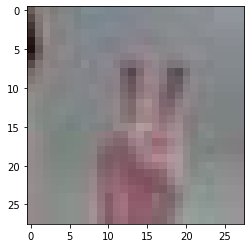

In [5]:
# 맞는지 시각화

import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [6]:
# 딥러닝 네트워크 설계

# 패키지 설치
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?

# 32 64 64 10 : 0.4900
# 32 64 128 10 : 0.4867
# 32 64 256 10 : 0.4467
# 64 128 128 10 : 0.4933 / 0.5100 ==> 이거로 기준 설정
# 64 64 128 10 : 0.2933
# 64 128 512 10 : 0.4333
# 128 256 256 10 : 0.4633
# 128 256 512 10 : 0.4833

# epochs? 
# 64 128 128 8 : 0.5400 / 0.4333
# 64 128 512 8 : 0.4533
# 128 256 512 12 : 0.5333 / 0.5100 / 0.4367
# 128 256 512 15 : 0.4733

n_channel_1=64
n_channel_2=128
n_dense=128
n_train_epoch=30

# 뒤에 28, 28, 3 으로 바꿀 것
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [7]:
# 딥러닝 네트워크 학습

# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.

# 채널 수에 대한 정보 (RGB=3)
# print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
# x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)
# print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))
      
# 학습 시키기
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),   ## 제발!!! 오네가이!!!! 좀 !!!!        #'adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=30)

Epoch 1/30
469/469 [==============================] - 5s 10ms/step - loss: 0.8429 - accuracy: 0.5925
Epoch 2/30
469/469 [==============================] - 1s 2ms/step - loss: 0.4525 - accuracy: 0.8277
Epoch 3/30
469/469 [==============================] - 1s 2ms/step - loss: 0.2753 - accuracy: 0.9025
Epoch 4/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1710 - accuracy: 0.9412
Epoch 5/30
469/469 [==============================] - 1s 2ms/step - loss: 0.1060 - accuracy: 0.9690
Epoch 6/30
469/469 [==============================] - 1s 3ms/step - loss: 0.0653 - accuracy: 0.9832
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.0484 - accuracy: 0.9879
Epoch 8/30
469/469 [==============================] - 1s 3ms/step - loss: 0.0402 - accuracy: 0.9887
Epoch 9/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0260 - accuracy: 0.9933
Epoch 10/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0120 - accuracy: 0.998

In [8]:
# 딥러닝 test 데이터 만들기

# x_test, y_test를 만드는 방법은 x_train, y_train을 만드는 방법과 아주 유사합니다.
def re_load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/data/rsp/test"
(x_test, y_test)= re_load_data(image_dir_path)
x_test_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [9]:
# 모델평가

# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 2s - loss: 116.9888 - accuracy: 0.8333
test_loss: 116.98880004882812 
test_accuracy: 0.8333333134651184
